## Attention Machenism

### 心理学
* 动物需要在复杂环境下有效关注值得注意的点
* 心理学框架：人类根据随意线索和不随意线索选择注意点
    * 看到一个红色杯子：不随意搜索
    * 想读书：随意搜索(其实是active，随从自己的想法)

### 注意力机制
* 卷积、全连接、池化层都只考虑不随意搜索
* 注意力机制则显示的考虑随意搜索
    * 随意搜索被称为查询(query)
    * 每个输入是一个值(value)，和不随意搜索(key)的对
    * 通过注意力池化层来有偏向性的选择某些输入

![attention machenism](./imgs/attention_machenism.png)

### 非参注意力池化层
* 给定数据$(x_i, y_i), i = 1, ..., n$
* 平均池化是最简单的方案: $f(x) = \frac{1}{n}\Sigma_i y_i$
* 更好的方案是Nadaraya-Watson核回归(1960 or so)
$$
f(x) = \Sigma_{i = 1}^n \frac{K(x - x_i)}{\Sigma_{j = 1}^n K(x - x_j)}y_i
$$
其中x是query，x_i是key，y_i是value

### Nadaraya-Watson核回归
* 使用高斯核$K(u) = \frac{1}{\sqrt{2 \pi}} exp(-\frac{u^2}{2})$
* 则
$$
f(x) = \Sigma_{i = 1}^n \frac{exp(-\frac{1}{2} (x - x_i)^2)}{\Sigma_{j = 1}^n exp (-\frac{1}{1} (x - x_j)^2)} y_i\\
= \Sigma_{i = 1}^n softmax((-\frac{1}{2} (x - x_i)^2) y_i)
$$

### 参数化的注意力机制
* 在此前基础上引入可以学习的w
$$
f(x) = \Sigma_{i = 1}^n softmax(-\frac{1}{2}( (x - x_i)w)^2)y_i
$$

### 代码

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

In [2]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);


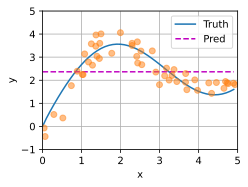

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

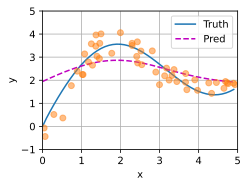

In [5]:

X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

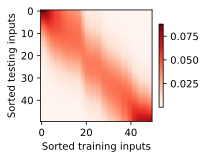

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [7]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [8]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [9]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [10]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))


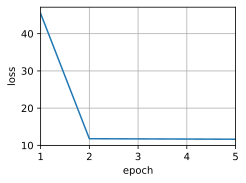

In [11]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

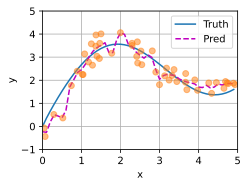

In [12]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

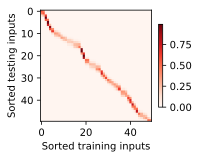

In [13]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 注意力分数
* 回顾：
$$
f(x) = \Sigma_i \alpha(x, x_i)y_i = \Sigma_{i = 1}^n softmax(-\frac{1}{2} (x - x_i)^2 )y_i
$$
其中：
* $\alpha$是注意力权重
* $-\frac{1}{2} (x - x_i)^2$是注意力分数

![attention score](./imgs/attention_fraction.png)

### 拓展到高维度
* 假设query $q \in R^q$, m对kay-value($k_1, v_1$), ..., 这里的$k_i \in R^k, v_i \in R$
* 注意力池化层

$$
f(q, (k_1, v_1), ..., (k_m, v_m)) = \Sigma_{i = 1}^m \alpha (q, k_i), v_i \in R^v
$$


$$
\alpha(q, k_i) = softmax(a(q, k_i)这个就是注意力分数) = \frac{exp(a(q, k_i))}{\Sigma_{j = 1}^m exp(a(q, k_j))} \in R
$$


### Additive Attention
* 可学参数：
$$
W_k \in R^{h*k}, W_q \in R^{h*q}, v \in R^h\\
a(k, q) = v^T tanh(W_k k + W_q q)
$$
* 等价于将key和value合并起来之后放入一个隐藏层为h，输出大小为1的单隐藏层MLP

### Scaled Dot-Product Attention
* 如果query和key都是同样长度$q, k_i \in R^d$，那么可以
$$
a(q, k_i) = <q, k_i> / \sqrt{d}
$$

* 向量化版本
    * $Q \in R^{n * d}, K \in R^{m * d}, V \in R^{n*m}$
    * 注意力分数：$ a(Q, K) = QK^T / \sqrt{d} \in R^{n * m} $
    * 注意力池化：$f = softmax(a(Q, K))V \in R^{n*v} $


summary
* 注意力分数是query和key的相似度，注意力权重是分数softmax结果
* 两种常见的分数运算
    * 一个是将query和key合并起来进入一个单输出单隐藏层的MLP
    * 直接将query和key做内积


### 代码


In [14]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [22]:
# 遮蔽masked softmax操作

def masked_softmax(X, valid_lens):
    '''通过最后一个轴上屏蔽元素来执行softmax操作'''
    if valid_lens is None:
        return nn.functional.softmax(X, dim=1)
    
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(
            X.reshape(-1, shape[-1]), 
            valid_lens, value=-1e6
        )
        return nn.functional.softmax(X.reshape(shape), dim=-1)
            

# 试一下
(masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])), 
 masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]])))

(tensor([[[0.4345, 0.5655, 0.0000, 0.0000],
          [0.5536, 0.4464, 0.0000, 0.0000]],
 
         [[0.3406, 0.2710, 0.3884, 0.0000],
          [0.5576, 0.2330, 0.2095, 0.0000]]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.2735, 0.4789, 0.2475, 0.0000]],
 
         [[0.5939, 0.4061, 0.0000, 0.0000],
          [0.3153, 0.2111, 0.3192, 0.1543]]]))

In [ ]:
# 可加注意力

class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, )

## 使用注意力机制的seq2seq

## 自注意力


## Transformer


## BERT预训练

## BERT微调

## 优化算法